In [4]:
%matplotlib ipympl 

import sys
sys.path.insert(1, '/user/scratch14_csa/jissa/NuGridPy')

import numpy as np
from matplotlib import pyplot as plt

from nugridpy import mesa as ms
from nugridpy import nugridse as nuse
from nugridpy import utils

import os
import sys
import contextlib
import pandas as pd

import h5py

from matplotlib import colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable

from astropy import constants as const
from astropy import units as u

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

# important feature!
from multizone import mppnp_reader

In [2]:
mesarun = ms.star_log("/data/nugrid/data/set1ext/set1.2/see_wind/M15.0Z2.0e-02/LOGS")
star = nuse.se("/data/nugrid/data/set1ext/set1.2/ppd_wind/M15.0Z2.0e-02/H5_out")
surf = nuse.se("/data/nugrid/data/set1ext/set1.2/ppd_wind/M15.0Z2.0e-02/H5_surf")

Using old star.logsa file ...
 reading ...100% 

Searching files, please wait.......
Reading preprocessor files
File search complete.
Searching files, please wait.......
Reading preprocessor files
File search complete.


In [3]:
star_age = mesarun.get('star_age')
model_number = mesarun.get('model_number')
Mdot = np.abs(mesarun.get('star_mdot'))
dt = np.power(10, mesarun.get('log_dt'))

dM = Mdot * dt
Mlost = np.cumsum(dM)

In [5]:
surface_elements_decayed = np.vstack(surf.get('elem_massf_decay'))
EMwind_decay = np.zeros(surface_elements_decayed.shape[1])

 reading ['elem_massf_decay']...100%

In [6]:
for i in range(surface_elements_decayed.shape[1]):

    EMwind_decay[i] = np.trapz(np.abs(Mdot) * surface_elements_decayed[:-2,i], star_age)

In [7]:
star.get_abundance_elem(21000)
decayed_elements = np.vstack(star.element_abundance_decayed)

 reading ['mass']...100%Using The following conditions:
	mass_range: 3.8433032128025213e-07 12.15340998801299
	cycle: 21000
 reading ['iso_massf']...100%WARNING:
This initial abundance file uses an element name that does
not contain the mass number in the 3rd to 5th position.
It is assumed that this is the proton and we will change
the name to 'h   1' to be consistent with the notation used in
iniab.dat files


In [9]:
ri_mass_21000 = star.get(21000, "mass")

def getyields():
        
        
    def get_idx(thing, what):
        
        return np.argmin(np.abs(thing-what))

    eles = star.se.isos[1:-2] # assume no At ? in elemental_abunds... whatever it is there is a discrepancy between len(eles) and len(list(set(star.se.Z)))    
            
    delay, rapid = get_idx(ri_mass_21000, 1.61), get_idx(ri_mass_21000, 1.44)
        
        
    # this is only SN yields... I need wind yields too...
        
        
    delayMej = ri_mass_21000[-1] - ri_mass_21000[delay]
    rapidMej = ri_mass_21000[-1] - ri_mass_21000[rapid]
        
    delayedEM = np.zeros(len(eles))
    rapidEM = np.zeros(len(eles))
        
    for i in range(len(eles)):
        
        delayedEM[i] = np.trapz(decayed_elements[delay:,i] , ri_mass_21000[delay:])

        rapidEM[i]   = np.trapz(decayed_elements[delay:,i] , ri_mass_21000[delay:])
        
    return eles, delayedEM, rapidEM, delayMej, rapidMej
    
eles, delayedEM, rapidEM, delayMej, rapidMej = getyields()

 reading ['mass']...100%

In [1]:
import pandas as pd

url = "https://download1.nugridstars.org/set1ext/Yield_tables/element_yield_table_MESAonly_fryer12_delay_pre_exp.txt"

# Try reading with automatic delimiter detection
df = pd.read_csv(url, delimiter='&',skiprows=765)

df = df.head(80)
df = df.drop(df.columns[0], axis=1)

df.head(10)

Isotopes   Yields      X0          Z 
0  H          6.526E+00   7.065E-01   1 
1  He         5.067E+00   2.735E-01   2 
2  Li         7.465E-11   7.605E-11   3 
3  B          3.824E-08   2.856E-09   5 
4  C          1.569E-01   3.466E-03   6 
5  N          5.003E-02   1.063E-03   7 
6  O          9.905E-01   9.650E-03   8 
7  F          4.799E-06   5.611E-07   9 
8  Ne         8.983E-02   1.969E-03   10
9  Na         2.720E-03   4.000E-05   11

In [12]:
from iniabu import ini # default: Loedders 2009 #https://pypi.org/project/iniabu/
ini._unit = 'mass_fraction'

In [17]:
def get_ritter(elements):
    
    comparisons = np.zeros(len(elements))
    
    for q, element in enumerate(elements):
        ele_solar = ini.ele[element].abu_solar
        fe_solar  = ini.ele["Fe"].abu_solar

        ele_idx = realele.index(element)
        fe_idx  = realele.index("Fe")
        
        comparison = np.log10(massX[ele_idx] / massX[fe_idx]) - np.log10(ele_solar / fe_solar)
        
        comparisons[q] = comparison
        
    return comparisons

In [18]:
get_ritter(['P', 'Cl', 'K', 'Sc'])

array([2.13313386, 2.13785574, 1.59174012, 1.79386303])

In [14]:
massX = df.iloc[:,1].astype(float).to_numpy()/np.sum(df.iloc[:,1].astype(float).to_numpy())

In [9]:
realele = df.iloc[:,0].astype(str).str.strip().to_list()

In [3]:
np.sum(delayedEM+EMwind_decay[1:-1])

NameError: name 'np' is not defined

In [56]:
for ele, rapid, wind in zip(eles, delayedEM, EMwind_decay[1:-1]):
    
    if ele in realele:
        q = realele.index(ele)
        
        realm, realx = df.iloc[q, 1], df.iloc[q, 2]
    else:
        realm, realx = ' ', ' '

    if realm != ' ': diff = f"{(float(realm)-(rapid+wind))/float(realm):.4e}"
    else: diff = ' '
        
        
    print(ele, '\t', f"{rapid+wind:.4e}", '\t', realm, '\t', diff)

H 	 6.5771e+00 	 6.526E+00  	 -7.8285e-03
He 	 5.0094e+00 	 5.067E+00  	 1.1359e-02
Li 	 6.9885e-11 	 7.465E-11  	 6.3828e-02
Be 	 4.6797e-26 	   	  
B 	 3.8219e-08 	 3.824E-08  	 5.5048e-04
C 	 1.5680e-01 	 1.569E-01  	 6.1800e-04
N 	 4.8983e-02 	 5.003E-02  	 2.0927e-02
O 	 9.9104e-01 	 9.905E-01  	 -5.4762e-04
F 	 4.8745e-06 	 4.799E-06  	 -1.5724e-02
Ne 	 8.9827e-02 	 8.983E-02  	 2.7850e-05
Na 	 2.7009e-03 	 2.720E-03  	 7.0364e-03
Mg 	 3.7546e-02 	 3.755E-02  	 1.0436e-04
Al 	 3.0198e-03 	 3.020E-03  	 6.0253e-05
Si 	 1.7572e-01 	 1.757E-01  	 -1.2339e-04
P 	 1.3545e-02 	 1.355E-02  	 3.4643e-04
S 	 2.0471e-01 	 2.048E-01  	 4.2747e-04
Cl 	 9.7679e-03 	 9.766E-03  	 -1.8969e-04
Ar 	 3.7032e-02 	 3.705E-02  	 4.7468e-04
K 	 2.2273e-03 	 2.227E-03  	 -1.3729e-04
Ca 	 1.7627e-03 	 1.764E-03  	 7.3128e-04
Sc 	 3.7304e-05 	 3.732E-05  	 4.1665e-04
Ti 	 1.5510e-04 	 1.552E-04  	 6.1830e-04
V 	 1.2328e-05 	 1.234E-05  	 1.0034e-03
Cr 	 3.0501e-04 	 3.052E-04  	 6.1200e-04
Mn 	 1.4572e-0

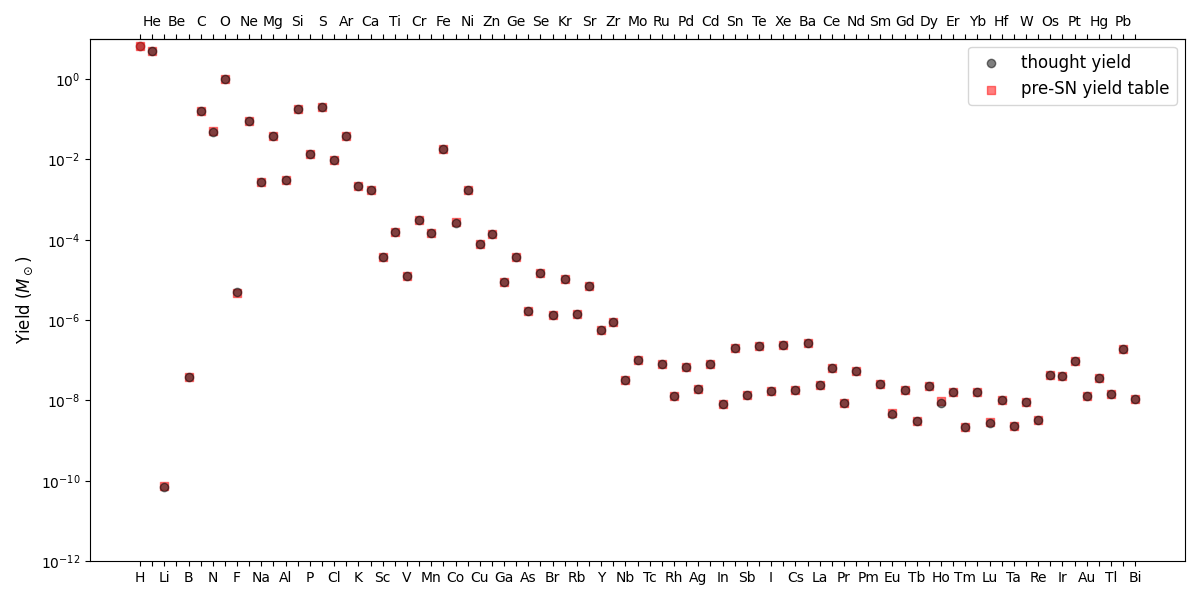

In [57]:
ifig = 1
plt.close(ifig)
fig, ax = plt.subplots(num=ifig, figsize=(12,6))

flag = False
for ele, rapid, EMwinddecay in zip(eles, delayedEM, EMwind_decay[1:-1]):
    if ele in realele:
        q = realele.index(ele)
        realm, realx = float(df.iloc[q, 1]), float(df.iloc[q, 2])
    else:
        realm, realx = np.nan, np.nan
    if not flag:
        ax.scatter(ele, rapid + EMwinddecay, color='black', label='thought yield', alpha=0.5)
        ax.scatter(ele, realm, color='red', label='pre-SN yield table', marker='s', alpha=0.5)
        flag=True
    else:
        ax.scatter(ele, realm, color='red', marker='s', alpha=0.5)
        ax.scatter(ele, rapid + EMwinddecay, color='black', alpha=0.5)


# Set y-axis to log scale
ax.set_yscale('log')

ax.set_ylabel(r'Yield $(M_\odot)$', fontsize='large')

ax.set_ylim(1e-12, 10)

# Split xticks: half on bottom, half on top
xticks = eles
ax.set_xticks(range(len(xticks)))
ax_top = ax.secondary_xaxis('top')  # create a top x-axis
ax_top.set_xticks(range(len(xticks)))

# Alternate labels
bottom_labels = [xticks[i] if i % 2 == 0 else "" for i in range(len(xticks))]
top_labels    = [xticks[i] if i % 2 == 1 else "" for i in range(len(xticks))]

ax.set_xticklabels(bottom_labels)
ax_top.set_xticklabels(top_labels)

plt.legend(fontsize='large')
plt.tight_layout()

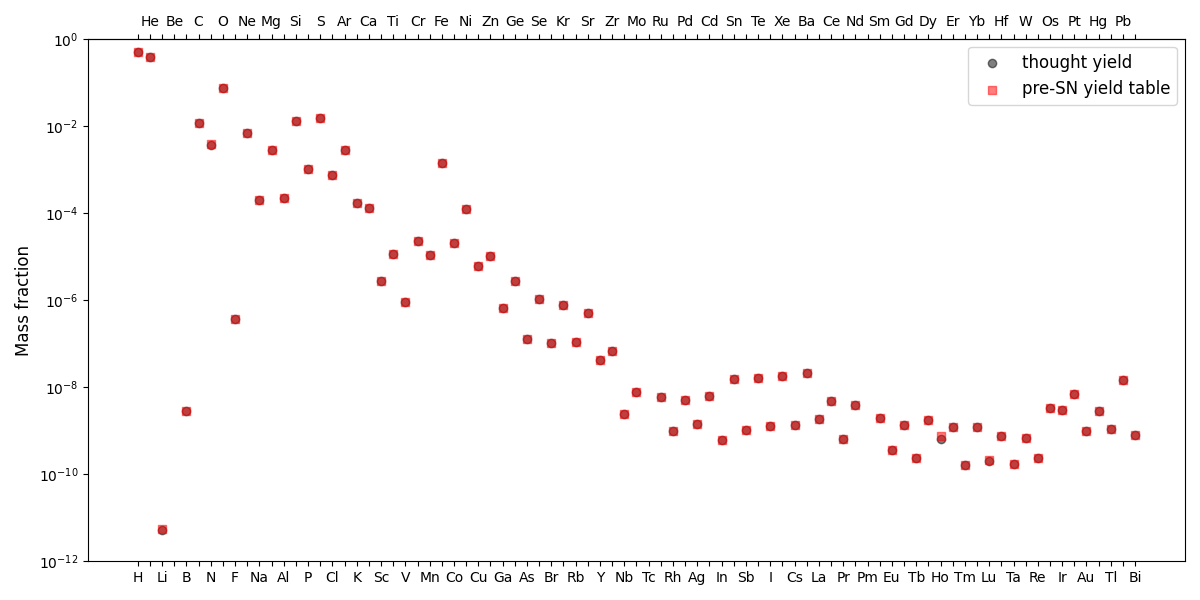

In [59]:
norm_me = np.sum(delayedEM + EMwind_decay[1:-1])
norm_ri = np.sum(df.iloc[:,1].astype(float).to_list())


ifig = 2
plt.close(ifig)
fig, ax = plt.subplots(num=ifig, figsize=(12,6))

flag = False
for ele, rapid, EMwinddecay in zip(eles, delayedEM, EMwind_decay[1:]):
    if ele in realele:
        q = realele.index(ele)
        realm = float(df.iloc[q, 1])/norm_ri
    else:
        realm = np.nan
    if not flag:
        ax.scatter(ele, (rapid + EMwinddecay)/norm_me, color='black', label='thought yield', alpha=0.5)
        ax.scatter(ele, realm, color='red', label='pre-SN yield table', marker='s', alpha=0.5)
        flag=True
    else:
        ax.scatter(ele, (rapid + EMwinddecay)/norm_me, color='black', alpha=0.5)
        ax.scatter(ele, realm, color='red', marker='s', alpha=0.5)

# Set y-axis to log scale
ax.set_yscale('log')

ax.set_ylabel(r'Mass fraction', fontsize='large')

ax.set_ylim(1e-12, 1)

# Split xticks: half on bottom, half on top
xticks = eles
ax.set_xticks(range(len(xticks)))
ax_top = ax.secondary_xaxis('top')  # create a top x-axis
ax_top.set_xticks(range(len(xticks)))

# Alternate labels
bottom_labels = [xticks[i] if i % 2 == 0 else "" for i in range(len(xticks))]
top_labels    = [xticks[i] if i % 2 == 1 else "" for i in range(len(xticks))]

ax.set_xticklabels(bottom_labels)
ax_top.set_xticklabels(top_labels)

plt.legend(fontsize='large')
plt.tight_layout()

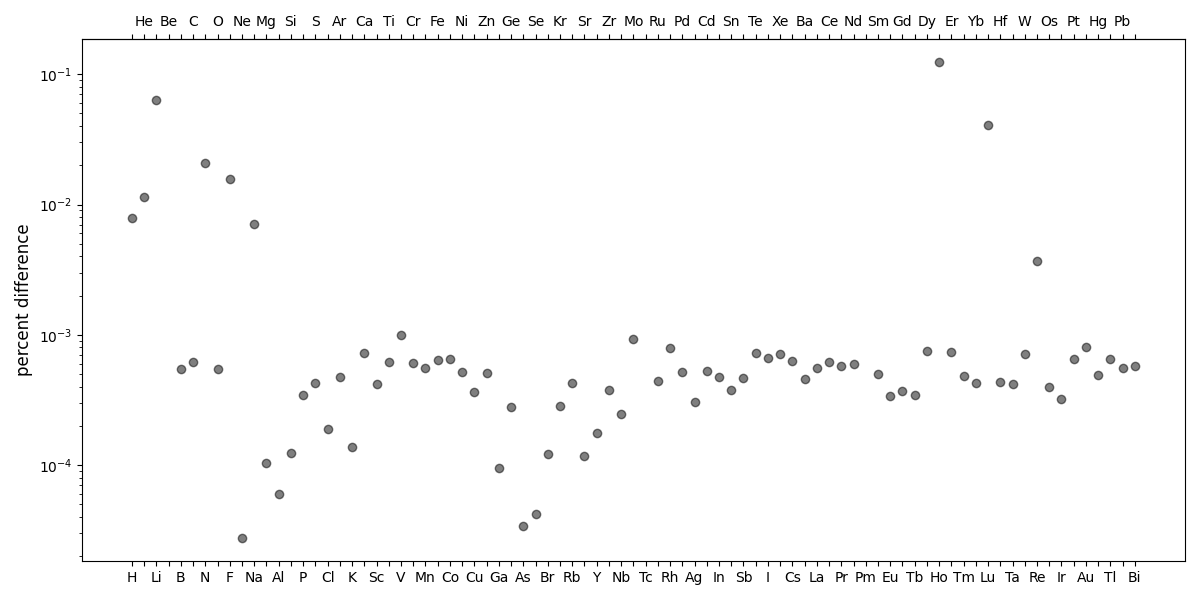

In [60]:
ifig = 3
plt.close(ifig)
fig, ax = plt.subplots(num=ifig, figsize=(12,6))

flag = False
for ele, rapid, EMwinddecay in zip(eles, delayedEM, EMwind_decay[1:]):
    if ele in realele:
        q = realele.index(ele)
        realm = float(df.iloc[q, 1])
        me_ = (rapid + EMwinddecay)
        
        
        ax.scatter(ele, np.abs((me_-realm) / realm), color='black', alpha=0.5)
    else:
        ax.scatter(ele, np.nan)
        
# Set y-axis to log scale
ax.set_yscale('log')

ax.set_ylabel('percent difference', fontsize='large')

# Split xticks: half on bottom, half on top
xticks = eles
ax.set_xticks(range(len(xticks)))
ax_top = ax.secondary_xaxis('top')  # create a top x-axis
ax_top.set_xticks(range(len(xticks)))

# Alternate labels
bottom_labels = [xticks[i] if i % 2 == 0 else "" for i in range(len(xticks))]
top_labels    = [xticks[i] if i % 2 == 1 else "" for i in range(len(xticks))]

ax.set_xticklabels(bottom_labels)
ax_top.set_xticklabels(top_labels)

plt.tight_layout()

In [62]:
import pandas as pd

url = "https://download1.nugridstars.org/set1ext/Yield_tables/element_yield_table_MESAonly_fryer12_delay_total.txt"

# Try reading with automatic delimiter detection
explosive = pd.read_csv(url, delimiter='&',skiprows=765)

explosive = explosive.head(80)
explosive = explosive.drop(explosive.columns[0], axis=1)

explosive.head(10)

Isotopes   Yields      X0          Z 
0  H          6.526E+00   7.065E-01   1 
1  He         5.067E+00   2.735E-01   2 
2  Li         7.674E-11   7.605E-11   3 
3  B          3.156E-08   2.856E-09   5 
4  C          1.553E-01   3.466E-03   6 
5  N          4.974E-02   1.063E-03   7 
6  O          9.218E-01   9.650E-03   8 
7  F          1.876E-05   5.611E-07   9 
8  Ne         8.810E-02   1.969E-03   10
9  Na         2.597E-03   4.000E-05   11

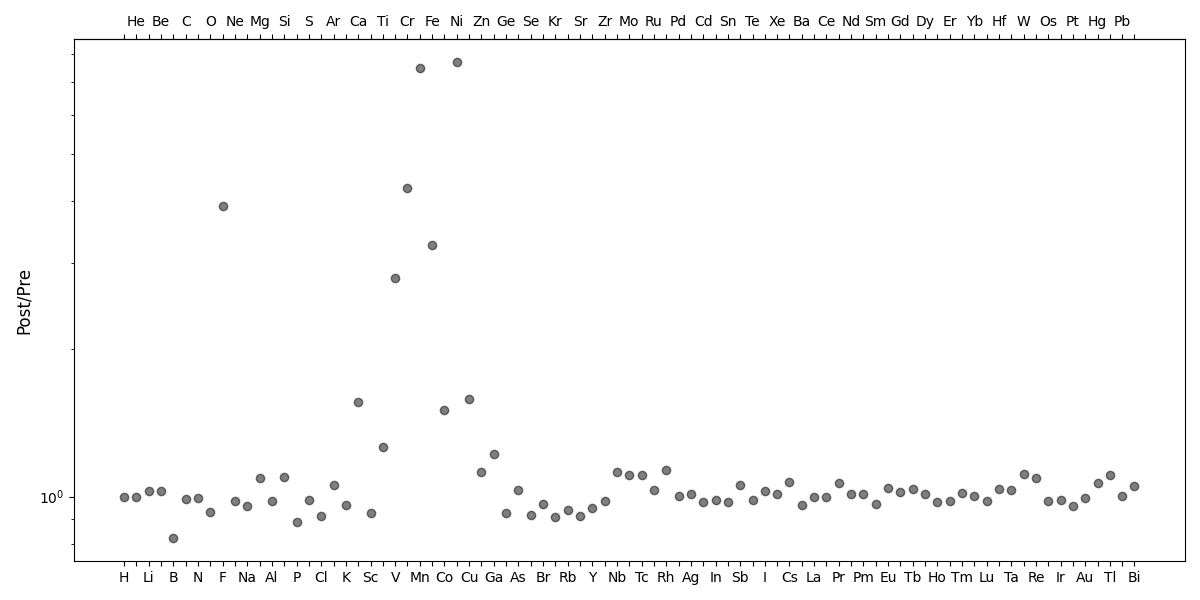

In [68]:
ifig = 1
plt.close(ifig)
fig, ax = plt.subplots(num=ifig, figsize=(12,6))

flag = False
for ele in eles:
    if ele in realele:
        q = realele.index(ele)

        pre = float(df.iloc[q,1])
        post = float(explosive.iloc[q,1])
        
    else:
        realm, realx = np.nan, np.nan

    ax.scatter(ele, post/pre, color='black', alpha=0.5)


# Set y-axis to log scale
ax.set_yscale('log')

ax.set_ylabel(r'Post/Pre', fontsize='large')

#ax.set_ylim(1e-12, 10)

# Split xticks: half on bottom, half on top
xticks = eles
ax.set_xticks(range(len(xticks)))
ax_top = ax.secondary_xaxis('top')  # create a top x-axis
ax_top.set_xticks(range(len(xticks)))

# Alternate labels
bottom_labels = [xticks[i] if i % 2 == 0 else "" for i in range(len(xticks))]
top_labels    = [xticks[i] if i % 2 == 1 else "" for i in range(len(xticks))]

ax.set_xticklabels(bottom_labels)
ax_top.set_xticklabels(top_labels)

plt.tight_layout()